# 11.7 AdaGrad算法
- **目录**
  - 11.7.1 稀疏特征和学习率
  - 11.7.2 AdaGrad算法预处理
  - 11.7.3 AdaGrad算法原理
  - 11.7.4 AdaGrad算法从零开始实现
  - 11.7.5 AdaGrad算法简洁实现

## 11.7.1 稀疏特征和学习率

假设我们正在训练一个语言模型。
为了获得良好的准确性，我们大多希望在训练的过程中降低学习率，速度通常为$\mathcal{O}(t^{-\frac{1}{2}})$或更低。
现在讨论关于**稀疏特征（即只在偶尔出现的特征）** 的模型训练，这对自然语言来说很常见。
例如，我们看到“预先条件”这个词比“学习”这个词的可能性要小得多。
但是，它在计算广告学和个性化协同过滤等其他领域也很常见。

只有在这些不常见的特征出现时，与其相关的参数才会得到有意义的更新。
鉴于学习率下降，我们可能最终会面临这样的情况：**常见特征的参数相当迅速地收敛到最佳值，而对于不常见的特征，我们仍缺乏足够的观测以确定其最佳值**。
换句话说，**学习率要么对于常见特征而言降低太慢，要么对于不常见特征而言降低太快**。

解决此问题的一个方法是记录我们**看到特定特征的次数**，然后将其用作调整学习率。
即我们可以使用大小为$\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$的学习率，而不是$\eta = \frac{\eta_0}{\sqrt{t + c}}$。
在这里<b>$s(i, t)$计下了我们截至$t$时观察到特征$i$的次数</b>。
这其实很容易实施且不产生额外损耗。

AdaGrad算法通过将粗略的计数器$s(i, t)$替换为先前观察所得梯度的平方之和来解决这个问题。
它使用$s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$来调整学习率。

这有两个好处：
- 首先，我们不再需要决定梯度何时算足够大。
- 其次，**它会随梯度的大小自动变化**。

通常对应于较大梯度的坐标会显著缩小，而其他梯度较小的坐标则会得到更平滑的处理。
在实际应用中，它促成了计算广告学及其相关问题中非常有效的优化程序。
但是，它遮盖了AdaGrad固有的一些额外优势，这些优势在预处理环境中很容易被理解。

- **要点：**
  -  **稀疏特征的挑战**: 
    - 在自然语言处理和其他领域（如计算广告学和个性化协同过滤）中，稀疏特征（即偶尔出现的特征）很常见。
     - 这些特征的处理对模型训练提出了挑战。
  - **学习率下降的影响**: 
    - 在训练过程中降低学习率通常有助于提高准确性。
    - 然而，学习率可能对常见特征降低太慢，或对不常见特征降低太快，导致不常见特征的参数难以收敛到最佳值。
  - **特征依赖的学习率调整**: 
    - 通过跟踪特定特征的出现次数，可以调整学习率，使其依赖于特征的稀疏性。
    - 例如，学习率可以设为$\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$，其中$s(i, t)$表示到时间$t$时观察到特征$i$的次数。
  - **AdaGrad算法的引入**: 
    - AdaGrad通过使用先前观察到的梯度的平方和来进一步优化这一过程。
    - 它自动调整学习率，**使其与梯度的大小相适应**。
  - **AdaGrad的优势**:
    - **自适应调整**: 不需要手动决定何时的梯度足够大，学习率会自动调整。
    - **与梯度大小的关系**: 对应于较大梯度的坐标会显著缩小，而较小梯度的坐标会得到更平滑的处理。
    - **实际应用的效果**: 在计算广告学等问题中，AdaGrad被证明是非常有效的优化程序。


## 11.7.2 AdaGrad算法预处理

凸优化问题有助于分析算法的特点。
毕竟对于大多数非凸问题来说，获得有意义的理论保证很难，但是直觉和洞察往往会延续。
让我们来看看最小化$f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$这一问题。

正如在11.6节中那样，我们可以根据其特征分解$\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$重写这个问题，来得到一个简化得多的问题，使每个坐标都可以单独解出：

$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b \tag{11.7.1}$$

在这里我们使用了$\bar{\mathbf{x}} = \mathbf{U} \mathbf{x}$，且因此$\bar{\mathbf{c}} = \mathbf{U} \mathbf{c}$。
（注意：中文版官方教材此处有错误！）

修改后优化器为$\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$且最小值为$-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$。
这样更容易计算，因为$\boldsymbol{\Lambda}$是一个包含$\mathbf{Q}$特征值的对角矩阵。

如果稍微扰动$\mathbf{c}$，我们会期望在$f$的最小化器中只产生微小的变化。
遗憾的是，情况并非如此。
虽然$\mathbf{c}$的微小变化导致了$\bar{\mathbf{c}}$同样的微小变化，但$f$的（以及$\bar{f}$的）最小化器并非如此。
每当特征值$\boldsymbol{\Lambda}_i$很大时，我们只会看到$\bar{x}_i$和$\bar{f}$的最小值发声微小变化。
相反，对于小的$\boldsymbol{\Lambda}_i$来说，$\bar{x}_i$的变化可能是剧烈的。
最大和最小的特征值之比称为优化问题的**条件数（condition number）**。

$$\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d} \tag{11.7.2}$$

如果**条件数$\kappa$很大，准确解决优化问题就会很难**。
我们需要确保在获取大量动态的特征值范围时足够谨慎：难道我们不能简单地通过扭曲空间来“修复”这个问题，从而使所有特征值都是$1$？
理论上这很容易：我们只需要$\mathbf{Q}$的特征值和特征向量即可将问题从$\mathbf{x}$整理到$\mathbf{z} := \boldsymbol{\Lambda}^{\frac{1}{2}} \mathbf{U} \mathbf{x}$中的一个。
在新的坐标系中，$\mathbf{x}^\top \mathbf{Q} \mathbf{x}$可以被简化为$\|\mathbf{z}\|^2$。
可惜，这是一个相当不切实际的想法。
一般而言，**计算特征值和特征向量要比解决实际问题“贵”得多**。

虽然准确计算特征值可能会很昂贵，但即便只是**大致猜测并计算它们**，也可能已经比不做任何事情好得多。
特别是，我们可以使用$\mathbf{Q}$的对角线条目并相应地重新缩放它。
这比计算特征值开销小的多。

$$\tilde{\mathbf{Q}} = \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \tag{11.7.3}$$

在这种情况下，我们得到了$\tilde{\mathbf{Q}}_{ij} = \mathbf{Q}_{ij} / \sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}$，特别注意对于所有$i$，$\tilde{\mathbf{Q}}_{ii} = 1$。
在大多数情况下，这大大**简化了条件数**。
例如我们之前讨论的案例，它将完全消除眼下的问题，因为问题是**轴对齐**的。

遗憾的是，我们还面临另一个问题：在深度学习中，我们通常情况甚至无法计算目标函数的二阶导数：对于$\mathbf{x} \in \mathbb{R}^d$，即使只在小批量上，二阶导数可能也需要$\mathcal{O}(d^2)$空间来计算，导致几乎不可行。
**AdaGrad算法巧妙的思路是，使用一个代理来表示黑塞矩阵（Hessian）的对角线，既相对易于计算又高效**。

为了了解它是如何生效的，让我们来看看$\bar{f}(\bar{\mathbf{x}})$。
我们有

$$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right) \tag{11.7.4}$$

其中$\bar{\mathbf{x}}_0$是$\bar{f}$的优化器。
因此，梯度的大小取决于$\boldsymbol{\Lambda}$和与最佳值的差值。
如果$\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$没有改变，那这就是我们所求的。
毕竟在这种情况下，梯度$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}})$的大小就足够了。
由于AdaGrad算法是一种随机梯度下降算法，所以即使是在最佳值中，我们也会看到具有非零方差的梯度。
因此，我们可以放心地使用梯度的方差作为黑塞矩阵比例的廉价替代。

- **要点：**
  - **凸优化问题的简化**：
    - 凸优化问题可以通过特征分解重写，使每个坐标都可以单独解出。
    - 具体来说，可以使用特征值和特征向量将问题从$\mathbf{x}$整理到$\mathbf{z}$中，从而简化问题的结构。
  - **条件数的影响**：
    - 优化问题的条件数$\kappa$衡量了最大和最小特征值之比。
    - 一个较大的条件数会使优化问题更难解决，因为在大量动态特征值范围内需要更加谨慎。
  - **空间扭曲和预处理**：
    - 可以通过扭曲空间来尝试解决特征值的问题，即使用$\mathbf{Q}$的特征值和特征向量，或者使用$\mathbf{Q}$的对角线条目并相应地重新缩放它。
    - 这样可以大大简化条件数，但并不总是可行。
  - **深度学习中的挑战**：
    - 在深度学习中，二阶导数的计算可能是不可行的，因为甚至在小批量上也需要大量空间来计算。
    - AdaGrad算法提供了一种巧妙的解决方案，使用一个代理来表示黑塞矩阵（Hessian）的对角线，既相对易于计算又高效。
  - **AdaGrad的工作原理**：
    - AdaGrad通过使用梯度的方差作为黑塞矩阵比例的廉价替代来工作。
    - 由于AdaGrad是随机梯度下降的一种形式，即使在最佳值中，梯度也会具有非零方差。
    - 这个观察使得AdaGrad能够有效地适应稀疏特征和不同的学习率需求。

---------

- **说明：**
- **（1）条件数对凸优化问题影响及其解决方法的通俗理解**
  - 预处理和凸优化问题：
    - 预处理是一种简化问题的方式。在凸优化的背景下，我们关注的是一种特殊的数学问题，其目的是找到使某个函数的值最小的变量组合。
    - 凸优化问题具有特殊的形状，使其更容易求解。
  - 简化问题-特征分解：
    - 假设我们有一个复杂的凸函数，我们可以通过一种叫做特征分解的方法将其变得更简单。
    - 想象有一个凸形物体，我们可以将其分解为一些更小的、更容易处理的部分。
    - 这就是特征分解所做的事情，它将问题分解为一些更简单的部分，使我们能够独立地解决每个部分。
  - 条件数-一个挑战：
    - 条件数衡量了这个问题有多难解决。
    - 如果条件数较大，那么即使只有一点点改变，最优解也可能会大幅度变化。
    - 这就像走在非常尖锐的山脊上，稍微偏离就会下滑到很远的地方。
  - 问题中的条件数：
    - 大的条件数可能使问题难以解决。
    - 可以想象，如果我们在一个高原上行走，有一些非常陡峭的部分，那么在这些部分走路将非常困难。
    - 因此应尽可能避免陡峭的地方。
  - 尝试解决条件数问题：
    - 一个想法是尝试“平坦”陡峭的部分，使所有地方都一样难走。
    - 这就是所谓的“空间扭曲”，可以通过一些数学技巧来实现。
    - 虽然这个想法理论上可行，但在实际中可能非常复杂和昂贵。
  - 更实用的解决方案：
    - 有一些更便宜的方法来缓解这个问题，比如重新调整问题的一些部分。
    - 这就像用一些垫子填平一些陡峭的地方，使整体走起来更容易。
  - 深度学习中的特殊挑战：
    - 在深度学习（一种强大的机器学习技术）中，我们通常不能准确地计算问题的陡峭部分。
    - 这就像走在一个未知的地形中，有时很难确定哪些地方特别陡峭。
  - AdaGrad-一个聪明的解决方案：
    - AdaGrad是一种算法，可以聪明地解决深度学习中的这个问题。
    - 它不是试图精确地找出陡峭的部分，而是观察走路的过程，并通过一些简单的数学技巧进行适当的调整。
    - 想象一下，你在行走时注意到脚下的地面，如果感觉到陡峭，就用更小的步伐走，这样就不会走得太远。

- **（2）条件数及其作用**
  - **条件数（Condition Number）** 的概念：
    - 条件数是数值分析中一个重要的概念，用来衡量矩阵的稳定性和敏感性。
    - 条件数大的矩阵被认为是“病态”的，因为它们对输入误差非常敏感。
    - 小的输入误差可能会导致大的输出误差。
    - 这在许多数学问题中都是不可取的，因为它使问题更难求解。
  - **计算方式**：
     - **特征值计算**：对于对称正定矩阵，条件数可以通过特征值计算：
   $$
   \kappa(A) = \frac{\lambda_{\text{max}}}{\lambda_{\text{min}}}
   $$   这里，$\lambda_{\text{max}}$和$\lambda_{\text{min}}$分别是矩阵的最大和最小特征值。
  - **条件数的阈值：**
    - 在线性回归中，如果条件数过大（例如，大于1000或10000），则可能表示存在多重共线性，即输入变量之间有强相关性。
    - 这使得线性模型的系数估计变得不稳定，解释和解释可能会很困难。
  - **在深度学习优化中的作用：**
    - 在深度学习的优化中，条件数可以用来度量梯度下降的速度和稳定性。
    - 大的条件数可能导致优化算法的收敛速度缓慢和不稳定。
    - 例如，AdaGrad算法通过适应性地调整学习率来处理不同条件数的问题。
      - 它可以看作是通过观察梯度的方差来估计条件数，并相应地调整学习率。
  - **示例：条件数计算**

In [30]:
'''
条件数的几种计算方式，但结果可能大相径庭。
对于对称或正定矩阵，numpy的eig函数是使用矩阵的最大特征值除以最小特征值。
如果矩阵不是对称或不是正定矩阵，那么二者的计算结果可能不一致。
通常使用矩阵的最大特征值除以最小特征值这种计算方式更可靠。
'''
import numpy as np
## 生成一个(3,3)的对称矩阵
C = np.random.rand(3, 3)
C = C@C.T
con1 = np.linalg.cond(C)
eig_values, _ = np.linalg.eig(C)
con2 = eig_values.max()/eig_values.min()
con1,con2

(205.29665753804974, 205.2966575380512)

- **（3）公式11.7.3 $\tilde{\mathbf{Q}} = \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q})$的作用与目的是什么？**
  - **特征标度调整**: 公式可能用于对矩阵的特定特征进行**重新缩放**。通过将矩阵$\mathbf{Q}$的对角线元素取逆平方根，我们实际上是在调整矩阵的缩放。这可能有助于使不同特征具有相同的尺度，从而改善某些算法的性能。
  - **谱归一化**: 在深度学习和机器学习的一些应用中，这种操作可能用于谱归一化。谱归一化可以限制权重矩阵的谱范数，从而有助于网络训练的稳定性和泛化能力。
  - **条件数改善**: 通过这种转换，矩阵的条件数可能得到改善。对于病态问题，改善条件数可能有助于**数值稳定性**，特别是在解线性方程组或进行优化时。
  - **相似性变换**: 这个操作也可以视为一种相似性变换，其中对角矩阵$\mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q})$对原始矩阵$\mathbf{Q}$进行了预条件。相似变换通常用于改变矩阵的某些性质，同时保持其基本结构不变，例如特征值。
  - 很显然，在此处公式11.7.3主要是为了条件数改善。

In [6]:
import numpy as np

def generate_symmetric_positive_definite_matrix(n):
    """
    生成一个对称正定矩阵 Q
    :param n: 矩阵的大小
    :return: 对称正定矩阵 Q
    """
    A = np.random.randn(n, n)
    Q = np.dot(A.T, A)  # 生成对称正定矩阵
    return Q

def rescale_matrix(Q):
    """
    根据公式 11.7.3 计算重新缩放后的矩阵
    :param Q: 原始对称正定矩阵
    :return: 重新缩放后的矩阵 Q_tilde
    """
    diag_elements = np.diag(Q)  # 提取对角线元素
    diag_inv_sqrt = np.diag(1 / np.sqrt(diag_elements))  # 对角线元素的逆平方根
    Q_tilde = diag_inv_sqrt @ Q @ diag_inv_sqrt  # 公式 11.7.3
    return Q_tilde

def analyze_matrices(Q, Q_tilde):
    """
    比较原始矩阵 Q 和重新缩放矩阵 Q_tilde 的特征值和条件数
    """
    # 原始矩阵的特征值和条件数
    eigvals_Q = np.linalg.eigvalsh(Q)
    cond_Q = np.max(eigvals_Q) / np.min(eigvals_Q)

    # 重新缩放矩阵的特征值和条件数
    eigvals_Q_tilde = np.linalg.eigvalsh(Q_tilde)
    cond_Q_tilde = np.max(eigvals_Q_tilde) / np.min(eigvals_Q_tilde)

    print("原始矩阵 Q 的特征值：", eigvals_Q)
    print("原始矩阵 Q 的条件数：", cond_Q)
    print("\n重新缩放矩阵 Q_tilde 的特征值：", eigvals_Q_tilde)
    print("重新缩放矩阵 Q_tilde 的条件数：", cond_Q_tilde)

# 主程序
np.random.seed(42)  # 设置随机种子，保证结果可复现

# 1. 生成对称正定矩阵 Q
n = 5  # 矩阵大小
Q = generate_symmetric_positive_definite_matrix(n)

# 2. 根据公式 11.7.3 计算重新缩放后的矩阵 Q_tilde
Q_tilde = rescale_matrix(Q)

# 3. 分析 Q 和 Q_tilde 的特征值和条件数
analyze_matrices(Q, Q_tilde)

原始矩阵 Q 的特征值： [ 0.05094072  1.68383256  3.01560023  4.58313201 13.29471652]
原始矩阵 Q 的条件数： 260.98406275127104

重新缩放矩阵 Q_tilde 的特征值： [0.01368491 0.66222659 0.98592688 1.25268798 2.08547365]
重新缩放矩阵 Q_tilde 的条件数： 152.39224472540863


- **（4）何为轴对齐，在深度学习的优化算法中有何作用？**
  - 在上文的情境中，所谓的轴对齐（axis-aligned）是指问题可以通过坐标变换或缩放来解决，使得优化问题在新的坐标系下具有更简单的结构。
    - 这样，每个坐标轴可以独立解决，因此称为轴对齐。
  - **原始问题：** 原始问题是最小化 $f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$，其中$\mathbf{Q}$ 是一个实对称矩阵。
  - **特征分解：** 通过特征分解，可以将$\mathbf{Q}$ 表示为$\mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$，其中$\boldsymbol{\Lambda}$是对角矩阵，包含$\mathbf{Q}$ 的特征值。
  - **轴对齐：** 
    - 问题转化为$\bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b$，使得每个坐标可以**单独解决**。
    - **这样的问题被称为轴对齐**，因为优化问题在新坐标系下的每个维度都可以独立解决。
  - **条件数与稳定性：** 
    - 条件数$\kappa$反映了问题的**敏感性**。
    - 较大的条件数意味着优化问题的解对输入的微小扰动更敏感。
    - 这是因为问题中包含了不同数量级的特征值，导致扰动在不同方向上的影响不同。
  - **轴对齐的转换：**
    - 通过$\tilde{\mathbf{Q}} = \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q})$的缩放，可以进一步**简化条件数**，使问题更接近轴对齐。
    - 这是一种近似方法，使问题在不同方向上的特征值更加一致，从而使问题的解对不同方向上的扰动更均匀敏感。
  - **轴对齐的意义：** 
    - 通过使问题轴对齐，我们可以更容易地理解和解决问题。
    - 每个坐标轴上的问题可以单独解决，这大大简化了计算。
    - 在上述例子中，轴对齐的转换是通过对角化问题的二次型部分来实现的，这使得在每个坐标轴上的优化变得独立。

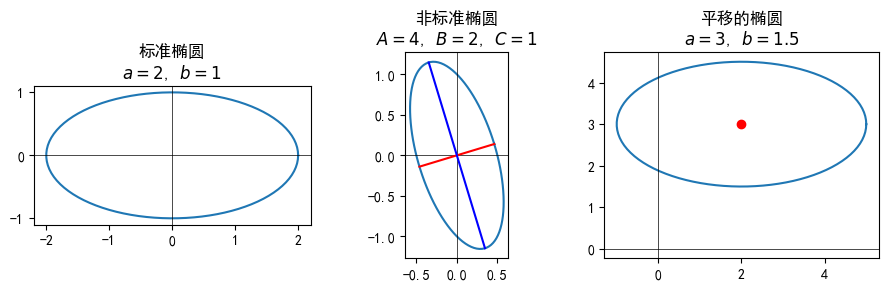

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 设置字体和负号显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 定义标准椭圆
def standard_ellipse(a, b):
    theta = np.linspace(0, 2 * np.pi, 100)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    return x, y

# 定义非标准椭圆
def non_standard_ellipse(A, B, C):
    # 构造二次型矩阵
    Q = np.array([[A, B/2], [B/2, C]])
    
    # 特征值分解
    eig_vals, eig_vecs = np.linalg.eig(Q)
    
    # 标准椭圆的半轴长度
    a = 1 / np.sqrt(eig_vals[0])
    b = 1 / np.sqrt(eig_vals[1])
    
    # 标准椭圆的参数
    theta = np.linspace(0, 2 * np.pi, 100)
    x_std = a * np.cos(theta)
    y_std = b * np.sin(theta)
    
    # 旋转到非标准椭圆的方向
    x = eig_vecs[0, 0] * x_std + eig_vecs[0, 1] * y_std
    y = eig_vecs[1, 0] * x_std + eig_vecs[1, 1] * y_std
    return x, y, eig_vecs, a, b

# 绘制中心点不在原点的轴对齐椭圆
def shifted_ellipse(a, b, h, k):
    x, y = standard_ellipse(a, b)
    x_shifted = x + h
    y_shifted = y + k
    return x_shifted, y_shifted

# 绘制标准椭圆
a, b = 2, 1
x_std, y_std = standard_ellipse(a, b)

# 绘制非标准椭圆
A, B, C = 4, 2, 1
x_non_std, y_non_std, eig_vecs, a_std, b_std = non_standard_ellipse(A, B, C)

# 绘制中心点不在原点的轴对齐椭圆
a_shifted, b_shifted = 3, 1.5
h, k = 2, 3
x_shifted, y_shifted = shifted_ellipse(a_shifted, b_shifted, h, k)

# 绘制图形
plt.figure(figsize=(9, 3))

# 标准椭圆
plt.subplot(1, 3, 1)
plt.plot(x_std, y_std, label="标准椭圆")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title("标准椭圆\n$a=2$, $b=1$")
plt.gca().set_aspect('equal')

# 非标准椭圆
plt.subplot(1, 3, 2)
plt.plot(x_non_std, y_non_std, label="非标准椭圆")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# 绘制主轴方向的线条
# 主轴方向 1
x1 = np.array([-eig_vecs[0, 0] * a_std, eig_vecs[0, 0] * a_std])
y1 = np.array([-eig_vecs[1, 0] * a_std, eig_vecs[1, 0] * a_std])
plt.plot(x1, y1, color='r', label="主轴方向 1")

# 主轴方向 2
x2 = np.array([-eig_vecs[0, 1] * b_std, eig_vecs[0, 1] * b_std])
y2 = np.array([-eig_vecs[1, 1] * b_std, eig_vecs[1, 1] * b_std])
plt.plot(x2, y2, color='b', label="主轴方向 2")

plt.title("非标准椭圆\n$A=4$, $B=2$, $C=1$")
plt.gca().set_aspect('equal')

# 中心点不在原点的椭圆
plt.subplot(1, 3, 3)
plt.plot(x_shifted, y_shifted, label=f"平移椭圆\n中心=({h},{k})")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title("平移的椭圆\n$a=3$, $b=1.5$")
plt.scatter(h, k, color='red', zorder=5, label="椭圆中心")  # 标记中心
plt.gca().set_aspect('equal')
#plt.legend()

plt.tight_layout()
plt.show()

- **（5）公式11.7.4的推导过程**
  - 从凸二次问题公式11.7.1开始：
$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b$$ 其中，$\boldsymbol{\Lambda}$是一个包含$\mathbf{Q}$的特征值的对角矩阵。
  - Step 1: 求一阶导数
    - 首先需要找到$\bar{f}(\bar{\mathbf{x}})$关于$\bar{\mathbf{x}}$的一阶导数（即梯度）。对于二次函数，梯度可以通过以下公式计算：
$$\begin{align*}
\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) &= \partial_{\bar{\mathbf{x}}} \left(\frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}}\right) + \partial_{\bar{\mathbf{x}}} \left(\bar{\mathbf{c}}^\top \bar{\mathbf{x}}\right) + \partial_{\bar{\mathbf{x}}} b \\
&= \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}
\end{align*}$$
  - Step 2: 找到最优解
    - 要找到最优解$\bar{\mathbf{x}}_0$，我们需要找到使梯度为零的点，即解方程：
$$\boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = 0$$解得：
$$\bar{\mathbf{x}}_0 = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$$
  - Step 3: 代入最优解
    - 现在可以将$\bar{\mathbf{x}}_0$代入梯度表达式：
$$\begin{align*}
\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) &= \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} \\
&= \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right) \\
&= \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} + \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}\right) \tag{11.7.4}
\end{align*}$$这个等式说明了梯度的大小是由$\boldsymbol{\Lambda}$和与最优解的距离$\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$共同决定的。如果$\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$没有改变，梯度的大小就足够了，因此我们可以使用梯度的方差作为黑塞矩阵比例的廉价替代。

---------

## 11.7.3 AdaGrad算法原理

让我们接着上面正式开始讨论。
我们使用变量$\mathbf{s}_t$来累加过去的梯度方差，如下所示：

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}  \tag{11.7.5}$$

在这里，操作是按照坐标顺序应用。
也就是说，$\mathbf{v}^2$有条目$v_i^2$。
同样，$\frac{1}{\sqrt{v}}$有条目$\frac{1}{\sqrt{v_i}}$，
并且$\mathbf{u} \cdot \mathbf{v}$有条目$u_i v_i$。
与之前一样，$\eta$是学习率，$\epsilon$是一个为维持数值稳定性而添加的常数，用来确保我们不会除以$0$。
最后，我们初始化$\mathbf{s}_0 = \mathbf{0}$。

就像在动量法中我们需要跟踪一个辅助变量一样，在AdaGrad算法中，我们允许**每个坐标有单独的学习率**。
与SGD算法相比，这并没有明显增加AdaGrad的计算代价，因为**主要计算用在$l(y_t, f(\mathbf{x}_t, \mathbf{w}))$及其导数**。

请注意，在$\mathbf{s}_t$中累加平方梯度意味着$\mathbf{s}_t$基本上以线性速率增长（由于梯度从最初开始衰减，实际上比线性慢一些）。
这产生了一个学习率$\mathcal{O}(t^{-\frac{1}{2}})$，但是在单个坐标的层面上进行了调整。
对于凸问题，这完全足够了。
然而，在深度学习中，我们可能希望**更慢地降低学习率**。
这引出了许多AdaGrad算法的变体，我们将在后续章节中讨论它们。
眼下让我们先看看它在二次凸问题中的表现如何。
我们仍然以同一函数为例：

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.  \tag{11.7.6}$$

我们将使用与之前相同的学习率来实现AdaGrad算法，即$\eta = 0.4$。
可以看到，自变量的迭代轨迹较平滑。
但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

- **要点：**
  - **梯度方差的累积**：
    - AdaGrad算法通过累积过去的梯度方差来自适应地调整每个坐标的学习率。
    - 对于每个时间步，算法保存了一个变量$\mathbf{s}_t$，用来累积过去梯度的平方。
  - **更新规则**：
    - 计算当前梯度$\mathbf{g}_t$。
    - 更新方差累积$\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$。
    - 更新权重$\mathbf{w}_t = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t$。
  - **按坐标操作**：上述操作按坐标顺序执行，每个坐标有自己的学习率。
  - **数值稳定性**：添加一个小常数$\epsilon$以确保不会出现除以$0$的情况。
  - **凸问题的适用性**：AdaGrad的学习率降低方式在凸问题中表现良好，但在深度学习中可能需要更慢地降低学习率。
  - **计算代价**：与SGD相比，计算代价没有显著增加。
  - **示例**：在给定的二次凸问题$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$上使用AdaGrad，迭代轨迹较为平滑，**学习率随着迭代而逐渐衰减**。
  - **与动量法的关系**：与动量法中需要跟踪一个辅助变量相似，AdaGrad允许每个坐标有单独的学习率。

In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l
import warnings
warnings.filterwarnings("ignore")

epoch 20, x1: -2.382563, x2: -0.158591


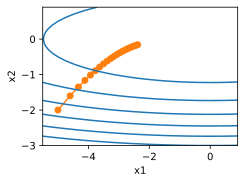

In [2]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

- 我们将学习率提高到$2$，可以看到更好的表现。
- 这已经表明，即使在无噪声的情况下，学习率的降低可能相当剧烈，我们需要确保参数能够适当地收敛。


epoch 20, x1: -0.002295, x2: -0.000000


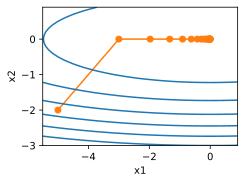

In [3]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## 11.7.4 AdaGrad算法从零开始实现

- 同动量法一样，AdaGrad算法需要**对每个自变量维护同它一样形状的状态变量**。


In [4]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

- 与 11.5节中的实验相比，使用更大的学习率来训练模型。


loss: 0.243, 0.032 sec/epoch


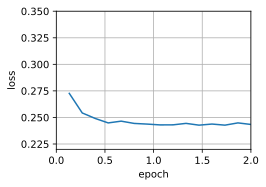

In [5]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

## 11.7.5 AdaGrad算法简洁实现

- 可直接使用深度学习框架中提供的AdaGrad算法来训练模型。


loss: 0.243, 0.035 sec/epoch


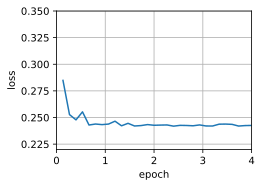

In [6]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

## 小结

* AdaGrad算法会在**单个坐标层面**动态降低学习率。
* AdaGrad算法利用梯度的大小作为调整进度速率的手段：**用较小的学习率来补偿带有较大梯度的坐标**。
* 在深度学习问题中，由于内存和计算限制，计算准确的二阶导数通常是不可行的。梯度可以作为一个有效的代理。
* 如果优化问题的结构相当不均匀，AdaGrad算法可以帮助缓解扭曲。
* AdaGrad算法对于稀疏特征特别有效，在此情况下由于不常出现的问题，学习率需要更慢地降低。
* 在深度学习问题上，AdaGrad算法有时在降低学习率方面可能过于剧烈。

